### TYK2 DMS/FlowDMS Integration with Barcode Subsampling

Combining protein stability data from FlowDMS and signaling activity data from standard DMS has proven powerful for identifying mutational signatures of interest (e.g. candidate allosteric sites). Consequently, we would like to evaluate the effect of reducing barcode sampling depth in one or both assays.

Resampled mapped counts files were generated with:

```
echo 3 5 8 10 15 | \
    tr " " "\n" | \
    parallel python src/resample-mapped-counts.py \
        -i pipeline/TYK2/OCNT-DMSLIB-1-assay-run7/tyk2.mapped-counts.tsv \
        -o pipeline/resample/tyk2-n{}.mapped-counts.tsv \
        -n {}

echo 3 5 8 10 15 | \
    tr " " "\n" | \
    parallel python src/resample-mapped-counts.py \
        -i pipeline/BMS/TYK2-FLOW/TYK2-FLOW.mapped-counts.tsv \
        -o pipeline/resample/tyk2-flow-n{}.mapped-counts.tsv \
        -n {}
```

Each generated set of counts was processed with the same pipeline as before, including the conversion of per-bin flowDMS summary statistics into midpoints. The sections below examine the effects of subsampling on each assay separately, and then on the results from combining them.

In [2]:
library(fs)
library(scales)
library(scico)
library(ggpubr)
library(emmeans)
library(broom)
library(broom.mixed)
library(tidyverse)

source("../src/dms-analysis-utils.R")

#### Subsampling FlowDMS

Rows: 23718 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): chunk, aa
dbl (10): score_mean, score_se, pos, WT score, WT score standard error, midp...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


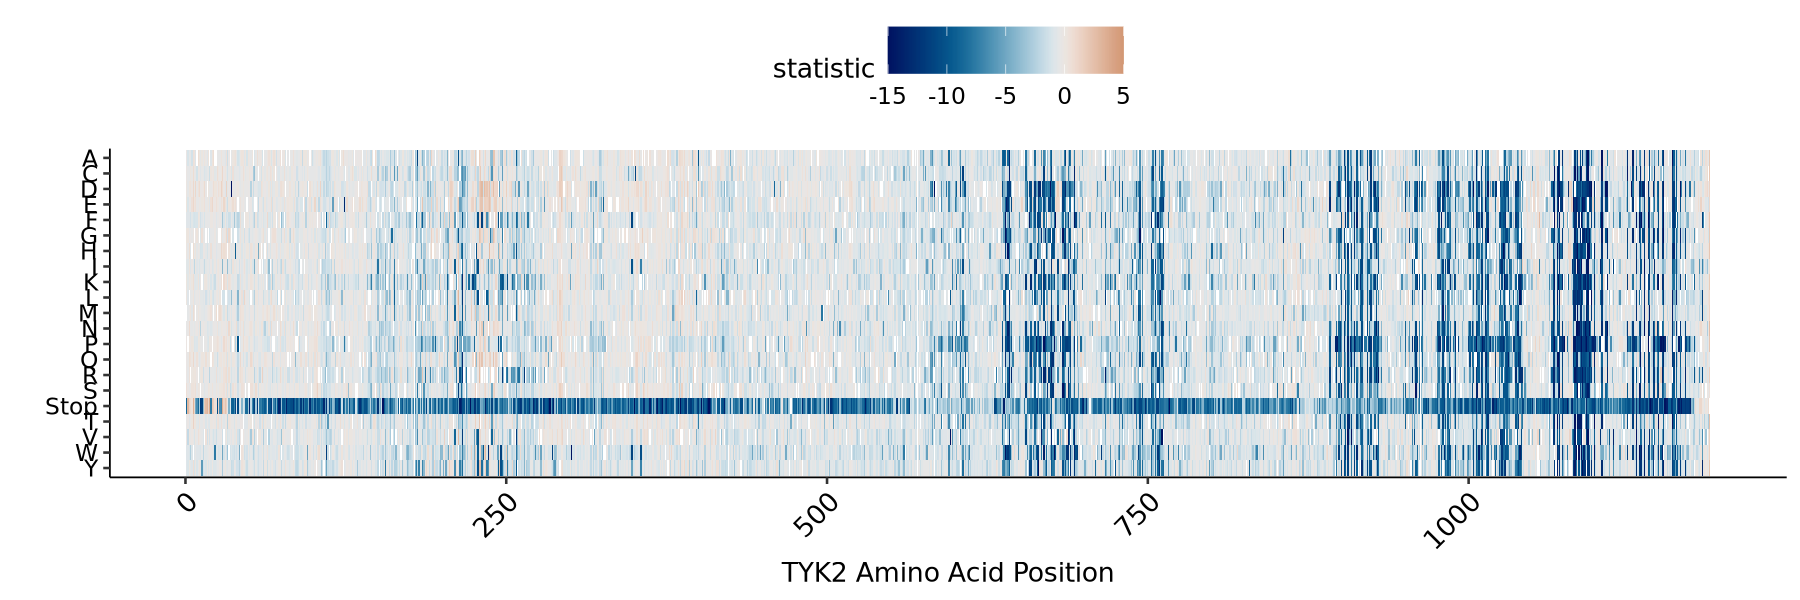

In [43]:
p <- read_tsv("../sumstats/TYK2-VAMP/run2B/tyk2-vamp-combined-flow-cleaned.midpoints.tsv") %>%
    mutate(aa = if_else(aa %in% c("X", "*"), "Stop", aa))

options(repr.plot.width = 15, repr.plot.height = 5)
p %>% 
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =statistic)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") 

Rows: 23718 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): chunk, mut_aa
dbl (10): score_mean, score_se, pos, WT score, WT score standard error, esti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


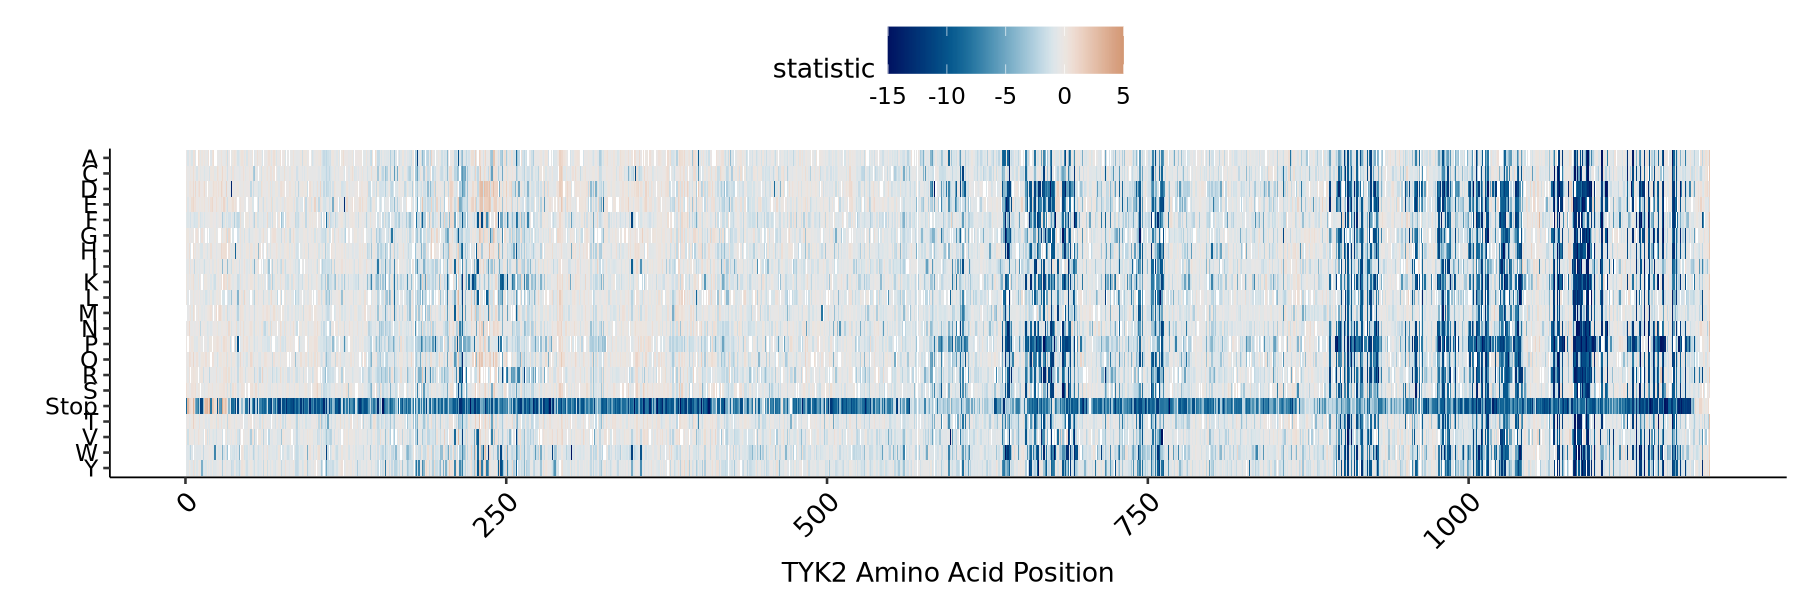

In [44]:
p <- read_tsv("../sumstats/TYK2-VAMP/run2B/OCNT-VAMPLIB-1-assay-run2B-vampseq-midpoints.sumstats.tsv") %>%
    mutate(mut_aa = if_else(mut_aa %in% c("X", "*"), "Stop", mut_aa))

options(repr.plot.width = 15, repr.plot.height = 5)
p %>% 
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill =statistic)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") 

In [63]:
flow_files <- dir_ls("../sumstats/resample", glob = "*.midpoints.tsv")
flow_sumstats <- read_tsv(flow_files, id = "n") %>%
    mutate(n = gsub("../sumstats/resample/tyk2-flow-|-flow-cleaned.midpoints.tsv", "", n),
           n = factor(n, levels = c("n3", "n5", "n8", "n10", "n15")),
           aa = if_else(aa %in% c("X", "*"), "Stop", aa))


Rows: 117835 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): chunk, aa
dbl (10): score_mean, score_se, pos, WT score, WT score standard error, midp...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


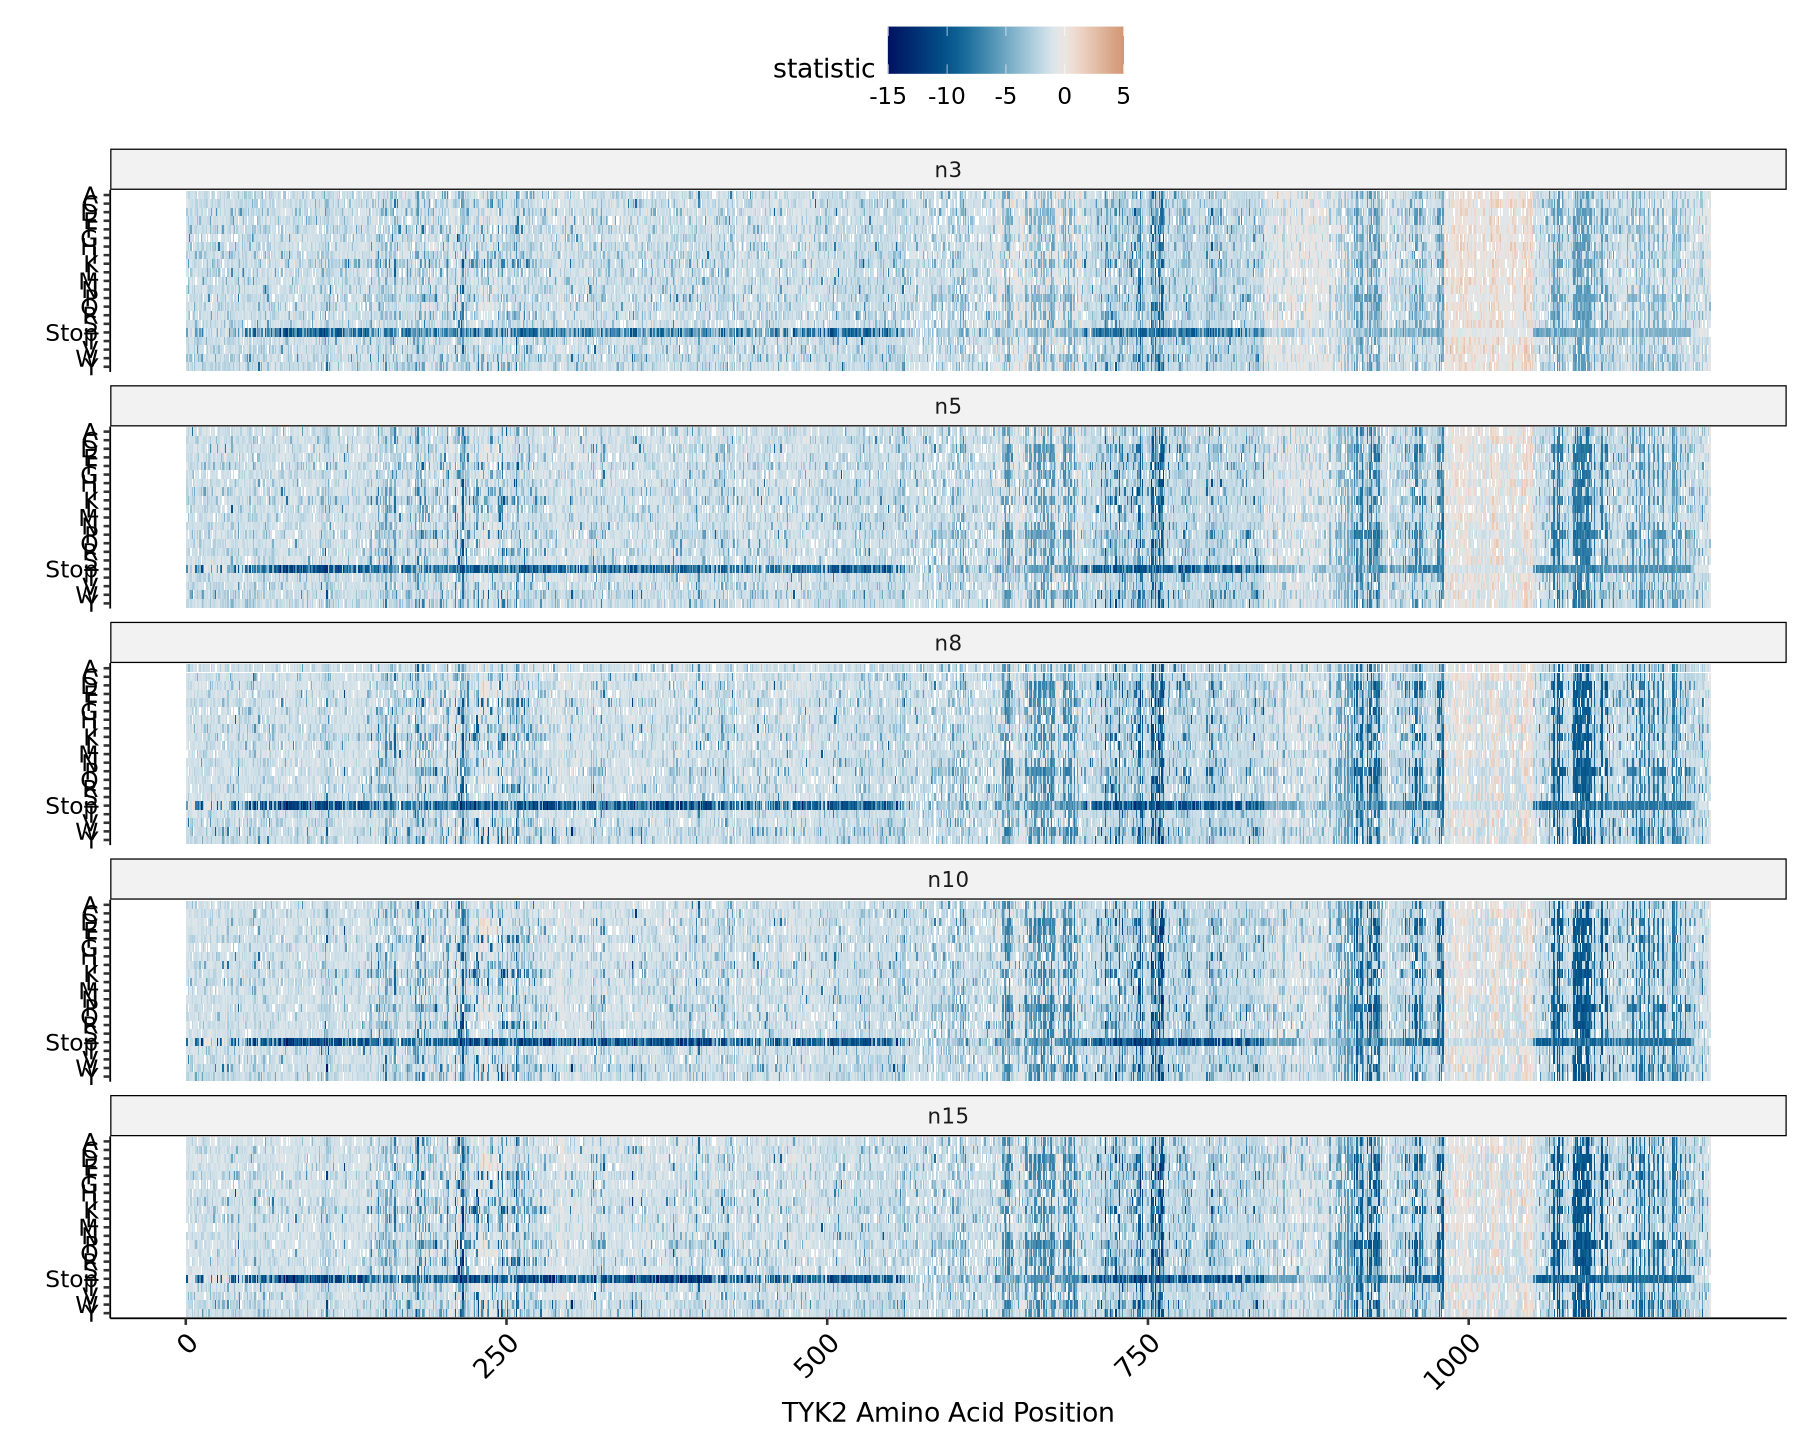

In [65]:
options(repr.plot.width = 15, repr.plot.height = 12)
flow_sumstats %>% 
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =statistic)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~n, ncol = 1)

#### Subsampling Signaling DMS

In [48]:
dms_files <- dir_ls("../sumstats/resample", glob = "*-cleaned.sumstats.tsv")
dms_sumstats <- read_tsv(dms_files, id = "n") %>%
    mutate(n = gsub("../sumstats/resample/tyk2-|-combined-cleaned.sumstats.tsv", "", n),
           n = factor(n, levels = c("n3", "n5", "n8", "n10", "n15")),
           aa = if_else(aa %in% c("X", "*"), "Stop", aa))

Rows: 593475 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chunk, condition, aa, version
dbl (5): pos, log2FoldChange, log2StdError, statistic, p.value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


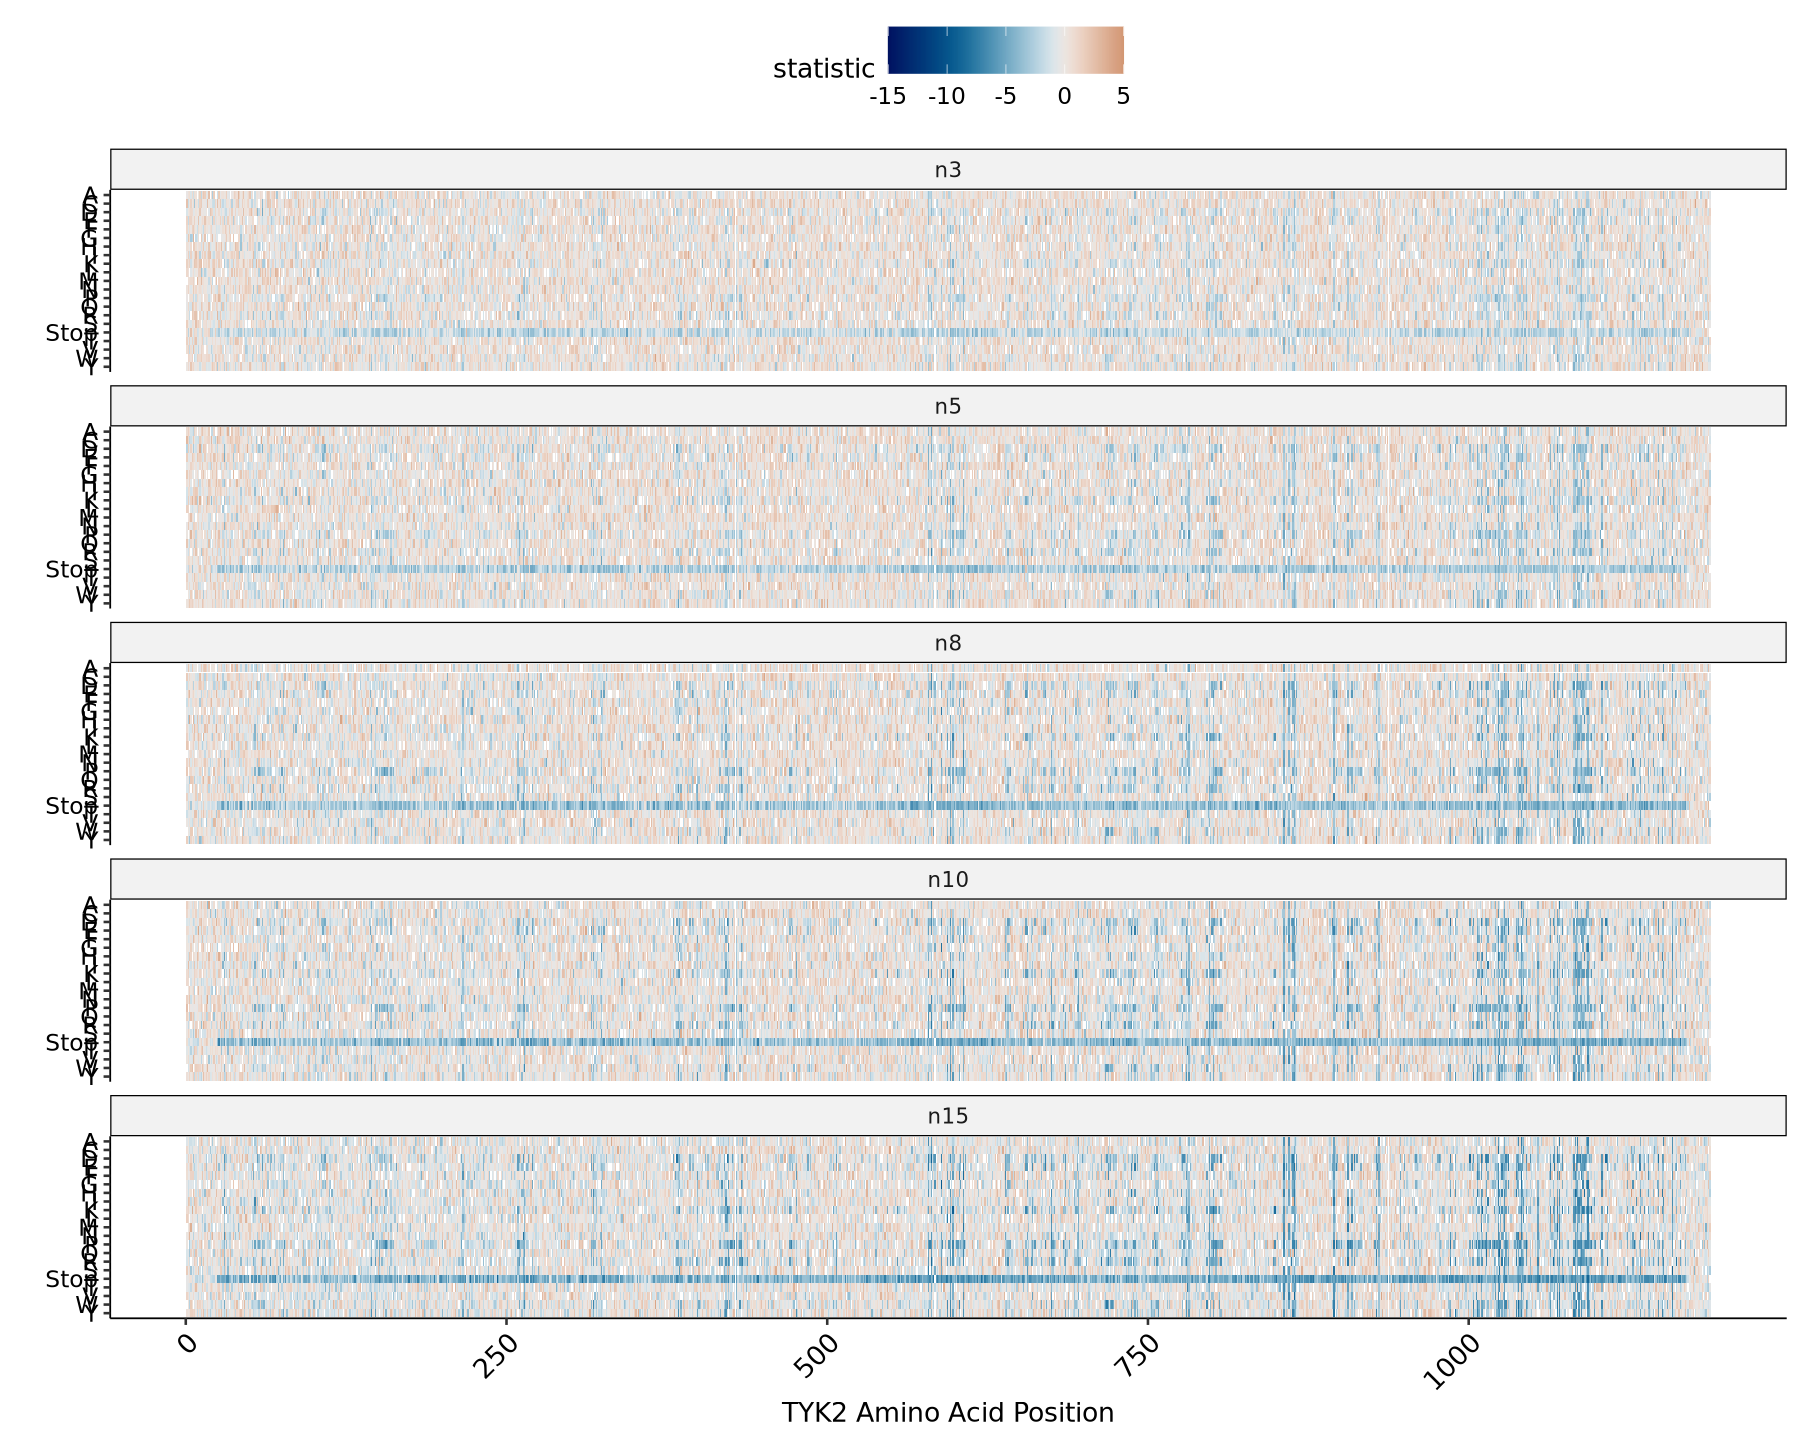

In [51]:
options(repr.plot.width = 15, repr.plot.height = 12)
dms_sumstats %>% 
    filter(condition == "IFNalpha100_0") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =statistic)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~n, ncol = 1)

#### Matched Subsampling 